## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [1]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'

In [3]:
data_df = pd.read_csv(data_location + file)

In [4]:
data_df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [5]:
data_df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [6]:
m = NeuralProphet()

{'self': <neuralprophet.forecaster.NeuralProphet object at 0x7f99c27a35e0>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


In [7]:
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

In [8]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [9]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-10-08 01:00:00
Validation set time range:   2015-10-08 02:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


**Plot train_df**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
x_size = 16
y_size = 6
figsize = (x_size, y_size)

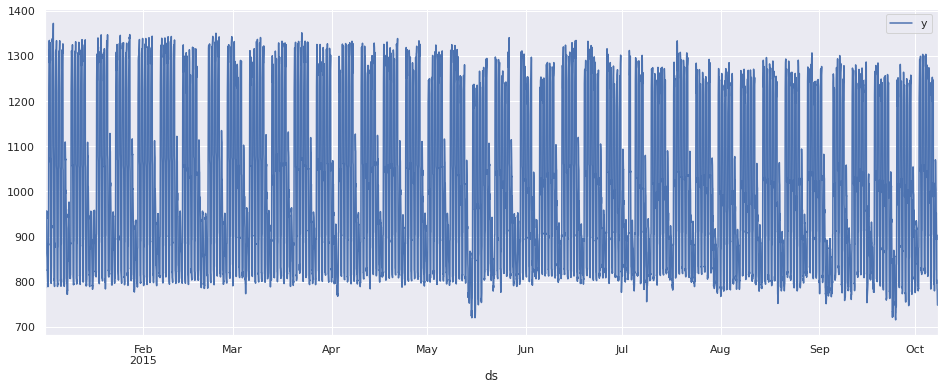

In [12]:
train_df.set_index('ds').plot(figsize=figsize);

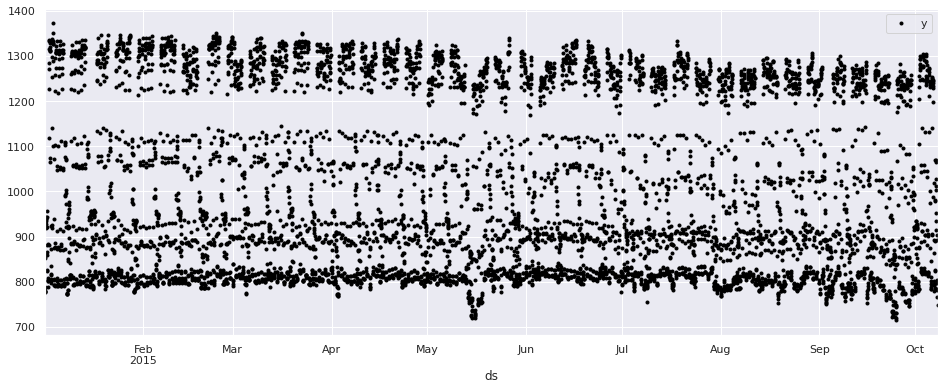

In [13]:
train_df.set_index('ds').plot(marker='.', linestyle='none', colormap='gray', figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: Generic forecast of time-based features (like Facebook Prophet)
- `m2`: NP with 1-layer AR
- `m3`: NP with 4-layer deep AR

In [14]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]

In [15]:
m1 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m2 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate = 0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


{'self': <neuralprophet.forecaster.NeuralProphet object at 0x7f99a862a3a0>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 1, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 6, 'daily_seasonality': 10, 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': 0.01, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': [0.05, 0.95], 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}
{'self': <neuralprophet.forecaster.NeuralProphet object at 0x7f99a862a670>, 'grow

In [16]:
%%time
random_seed = 0
set_random_seed(random_seed)
metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
# metrics3 = m3.fit(train_df, freq='H', validation_df=val_df, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 114
  0%|          | 0/114 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([746])) that is different to the input size (torch.Size([746, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduct

CPU times: user 6min 23s, sys: 332 ms, total: 6min 23s
Wall time: 2min 45s


In [17]:
metrics1.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.005676,44.631943,61.431704,0.01012,0.004564,0.107314,223.560593,276.480316


In [18]:
metrics2.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.001826,23.78648,35.067682,0.003231,0.001203,0.10699,218.762833,276.046082


In [19]:
metrics3.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.000155,7.240371,10.177473,0.000155,0.0,0.108465,219.429321,277.942871


### Conformalize and plot

In [20]:
alpha = 0.1

**Naive**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


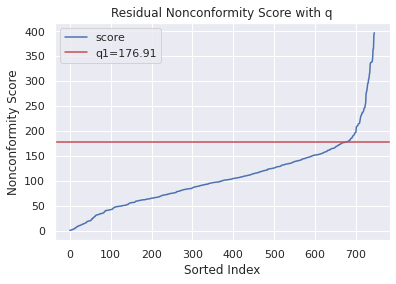

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


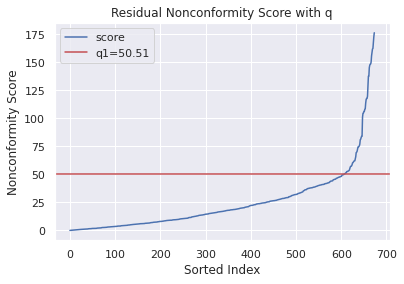

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


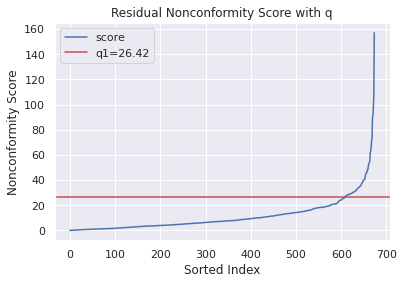

In [21]:
method='residual'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)

In [22]:
naive_qhat1, naive_qhat2, naive_qhat3 = m1.q_hat, m2.q_hat, m3.q_hat
naive_qhat1, naive_qhat2, naive_qhat3

(176.90842283828124, 50.513631634374974, 26.418522632812483)

In [23]:
naive_forecast1 = m1.predict(test_df)
naive_forecast2 = m2.predict(test_df)
naive_forecast3 = m3.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [24]:
# method='residual'
# naive_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [25]:
naive_forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,-15.913307,787.497559,582.228088,856.345703,919.481689,-125.087540,-6.896573,610.589136,964.405981
1,2015-12-09 07:00:00,868.264194,30.227017,898.491211,715.709717,952.476440,919.447021,-138.309204,117.353439,721.582788,1075.399634
2,2015-12-09 08:00:00,975.752982,-57.155570,918.597412,762.452820,968.547424,919.412354,-147.846558,147.031616,741.688989,1095.505835
3,2015-12-09 09:00:00,983.268943,-30.229392,953.039551,788.535583,990.964233,919.377625,-153.484116,187.146027,776.131128,1129.947974
4,2015-12-09 10:00:00,1095.825986,-142.754331,953.071655,798.758240,986.817200,919.343018,-155.179886,188.908585,776.163232,1129.980078
...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,-203.049775,642.513306,491.548157,689.260254,900.687744,-161.652573,-96.521873,465.604883,819.421729
543,2015-12-31 21:00:00,827.530521,-216.565189,610.965332,472.376221,671.093506,900.653076,-133.658920,-156.028824,434.056909,787.873755
544,2015-12-31 22:00:00,829.256300,-217.894056,611.362244,461.588745,651.608521,900.618347,-104.345787,-184.910339,434.453821,788.270666
545,2015-12-31 23:00:00,813.937205,-188.365550,625.571655,473.997742,674.857544,900.583740,-74.646706,-200.365326,448.663232,802.480078


In [26]:
naive_forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,6.577911,852.140991,811.594238,895.508667,103.758713,748.382263,801.62736,902.654623
543,2015-12-31 21:00:00,827.530521,-53.622318,773.908203,733.36322,817.275635,25.525883,748.382263,723.394571,824.421835
544,2015-12-31 22:00:00,829.256300,-5.542066,823.714233,783.170898,867.081665,75.33197,748.382263,773.200602,874.227865
545,2015-12-31 23:00:00,813.937205,24.424733,838.361938,797.819031,881.729492,89.97963,748.382263,787.848307,888.87557


In [27]:
naive_forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,2.199859,847.762939,838.656372,855.743652,-103.348923,951.111877,821.344417,874.181462
543,2015-12-31 21:00:00,827.530521,-8.931888,818.598633,813.212341,825.671204,-132.51326,951.111877,792.18011,845.017155
544,2015-12-31 22:00:00,829.256300,-9.547804,819.708496,809.554565,827.430908,-131.403366,951.111877,793.289973,846.127019
545,2015-12-31 23:00:00,813.937205,1.082265,815.01947,804.521851,823.133667,-136.092438,951.111877,788.600948,841.437993


In [28]:
cutoff = 7*24 # 0
x_size = 12
y_size = 6
figsize = (x_size, y_size)
plotting_backend = 'default'

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


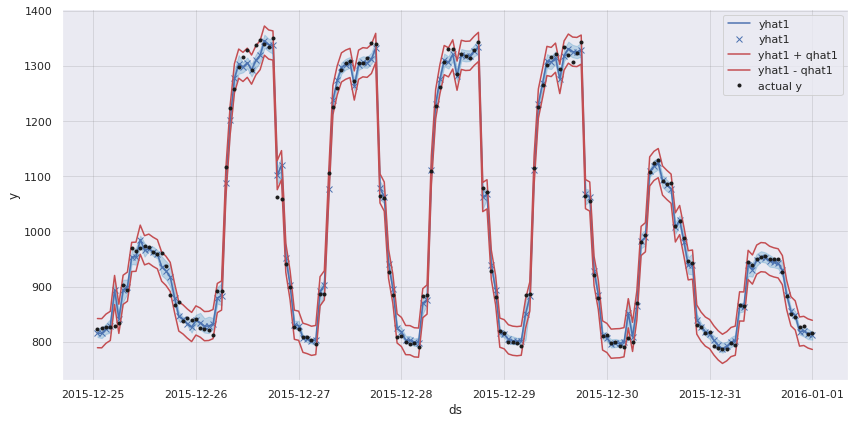

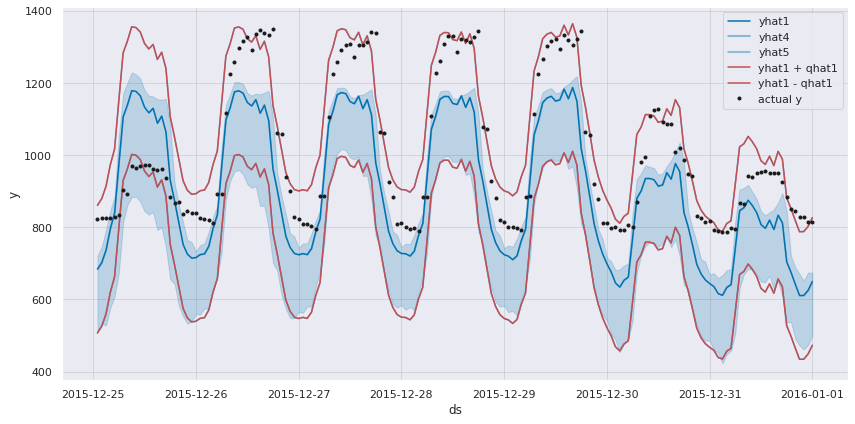

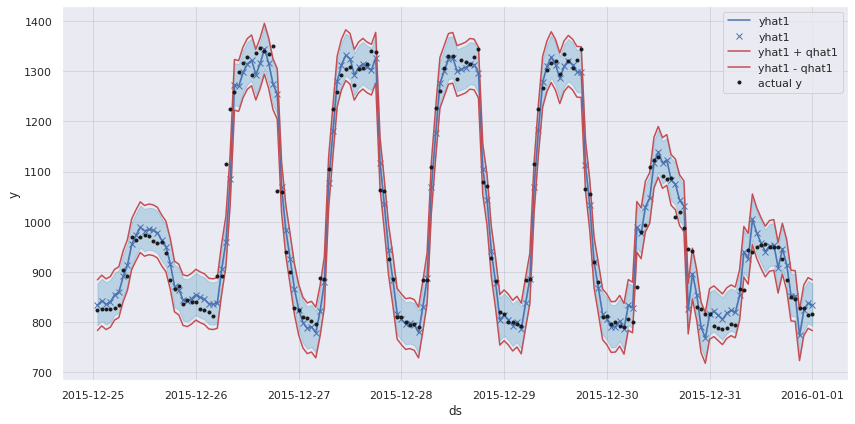

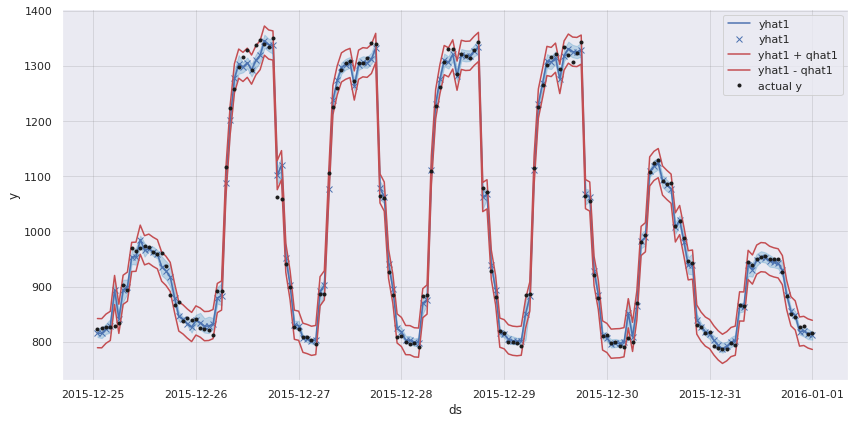

In [29]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)

m1.plot(naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m2.plot(naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m3.plot(naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


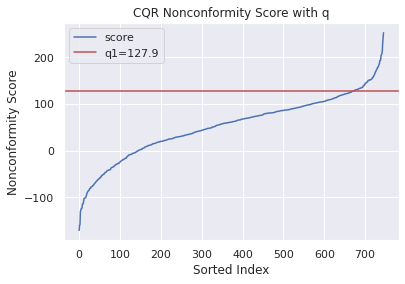

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


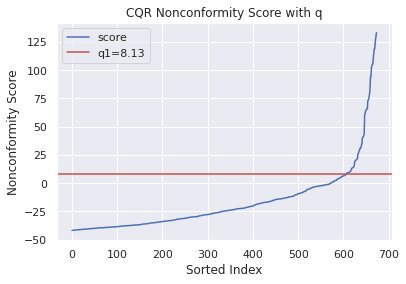

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


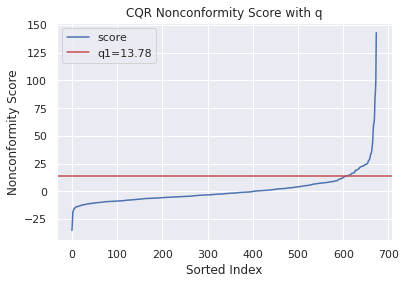

In [30]:
method='cqr'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)

In [31]:
cqr_qhat1, cqr_qhat2, cqr_qhat3 = m1.q_hat, m2.q_hat, m3.q_hat
cqr_qhat1, cqr_qhat2, cqr_qhat3

(127.89549846953128, 8.132101773437398, 13.77526935703122)

In [32]:
cqr_forecast1 = m1.predict(test_df)
cqr_forecast2 = m2.predict(test_df)
cqr_forecast3 = m3.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.818% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [33]:
# method='cqr'
# cqr_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [34]:
cqr_forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,-15.913307,787.497559,582.228088,856.345703,919.481689,-125.087540,-6.896573,728.450205,984.241202,454.332590,710.123587
1,2015-12-09 07:00:00,868.264194,30.227017,898.491211,715.709717,952.476440,919.447021,-138.309204,117.353439,824.580942,1080.371939,587.814218,843.605215
2,2015-12-09 08:00:00,975.752982,-57.155570,918.597412,762.452820,968.547424,919.412354,-147.846558,147.031616,840.651926,1096.442923,634.557321,890.348318
3,2015-12-09 09:00:00,983.268943,-30.229392,953.039551,788.535583,990.964233,919.377625,-153.484116,187.146027,863.068735,1118.859732,660.640085,916.431082
4,2015-12-09 10:00:00,1095.825986,-142.754331,953.071655,798.758240,986.817200,919.343018,-155.179886,188.908585,858.921701,1114.712698,670.862741,926.653738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,-203.049775,642.513306,491.548157,689.260254,900.687744,-161.652573,-96.521873,561.364755,817.155752,363.652658,619.443655
543,2015-12-31 21:00:00,827.530521,-216.565189,610.965332,472.376221,671.093506,900.653076,-133.658920,-156.028824,543.198007,798.989004,344.480722,600.271719
544,2015-12-31 22:00:00,829.256300,-217.894056,611.362244,461.588745,651.608521,900.618347,-104.345787,-184.910339,523.713022,779.504019,333.693247,589.484244
545,2015-12-31 23:00:00,813.937205,-188.365550,625.571655,473.997742,674.857544,900.583740,-74.646706,-200.365326,546.962045,802.753042,346.102243,601.893240


In [35]:
cqr_forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,6.577911,852.140991,811.594238,895.508667,103.758713,748.382263,887.376565,903.640769,803.462137,819.72634
543,2015-12-31 21:00:00,827.530521,-53.622318,773.908203,733.36322,817.275635,25.525883,748.382263,809.143533,825.407737,725.231118,741.495322
544,2015-12-31 22:00:00,829.256300,-5.542066,823.714233,783.170898,867.081665,75.33197,748.382263,858.949563,875.213767,775.038797,791.303
545,2015-12-31 23:00:00,813.937205,24.424733,838.361938,797.819031,881.729492,89.97963,748.382263,873.59739,889.861594,789.686929,805.951133


In [36]:
cqr_forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,2.199859,847.762939,838.656372,855.743652,-103.348923,951.111877,841.968383,869.518922,824.881103,852.431641
543,2015-12-31 21:00:00,827.530521,-8.931888,818.598633,813.212341,825.671204,-132.51326,951.111877,811.895934,839.446473,799.437072,826.987611
544,2015-12-31 22:00:00,829.256300,-9.547804,819.708496,809.554565,827.430908,-131.403366,951.111877,813.655639,841.206178,795.779296,823.329835
545,2015-12-31 23:00:00,813.937205,1.082265,815.01947,804.521851,823.133667,-136.092438,951.111877,809.358398,836.908936,790.746581,818.29712


WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


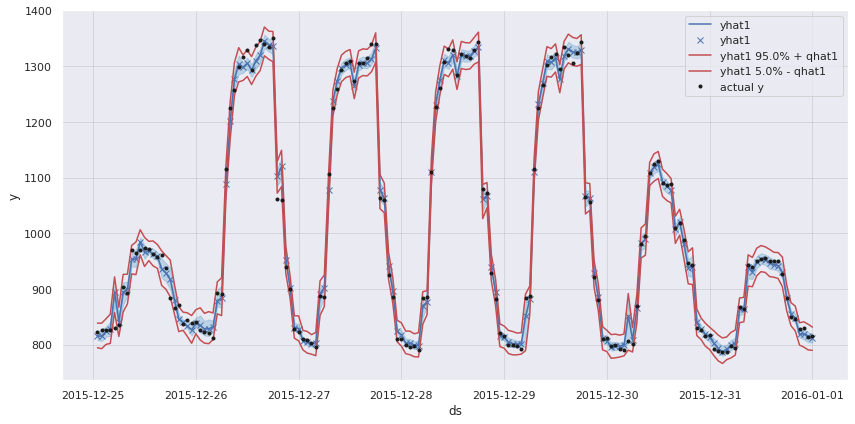

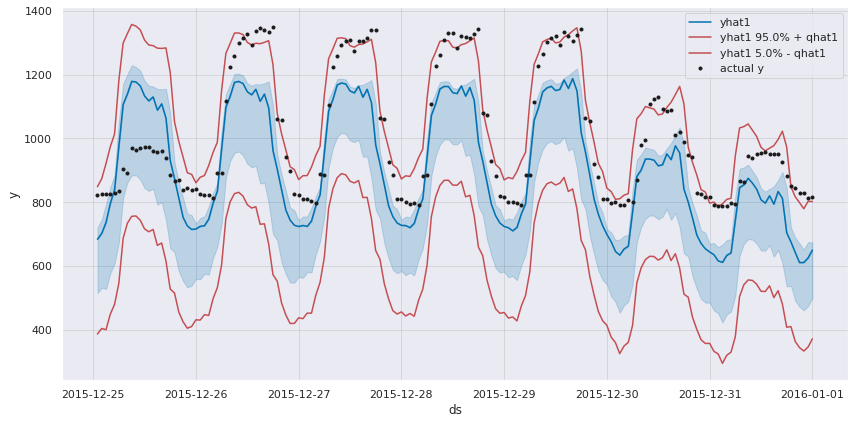

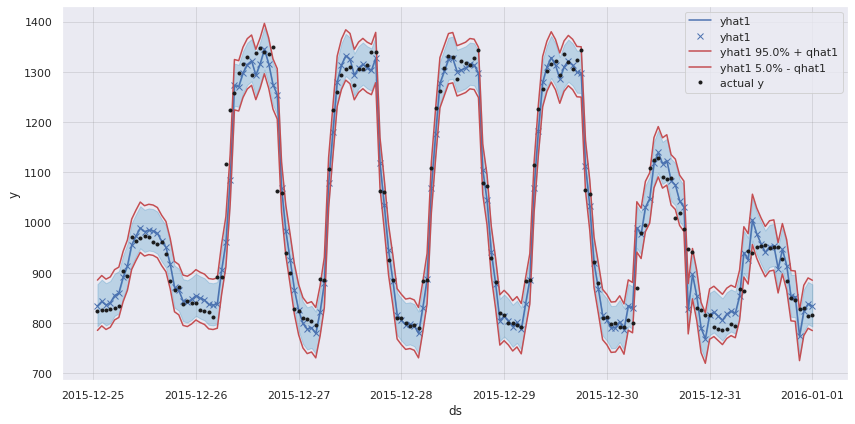

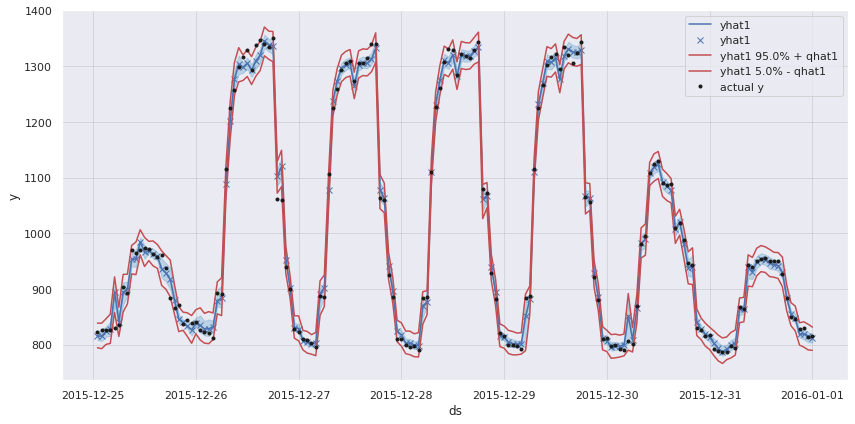

In [37]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)

m1.plot(cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m2.plot(cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m3.plot(cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [38]:
conformal_methods = ['residual', 'cqr']
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ['interval_width','miscoverage_rate']]))
eval_df = eval_df.reset_index().rename(columns={'index': 'model'})

Enter in the model names

In [39]:
eval_df['model'] = ['m1', 'm2', 'm3']

Enter in the **interval_width** (*efficiency* metric)

In [40]:
eval_df['residual', 'interval_width'] = [naive_qhat1*2, naive_qhat2*2, naive_qhat3*2]
eval_df['cqr', 'interval_width'] = [cqr_qhat1*2, cqr_qhat2*2, cqr_qhat3*2]

Enter in the **miscoverage rate** (*validity* metric)

In [41]:
naive_forecast1['check'] = naive_forecast1.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast2['check'] = naive_forecast2.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast3['check'] = naive_forecast3.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_coverage1 = naive_forecast1['check'].sum() / len(naive_forecast1)
naive_coverage2 = naive_forecast2['check'].sum() / len(naive_forecast2)
naive_coverage3 = naive_forecast3['check'].sum() / len(naive_forecast3)
eval_df['residual', 'miscoverage_rate'] = [1-naive_coverage1, 1-naive_coverage2, 1-naive_coverage3]  # 1 - coverage for the miscoverage

In [42]:
quantile_lo = str(quantile_lo*100)
quantile_hi = str(quantile_hi*100)
cqr_forecast1['check'] = cqr_forecast1.apply(lambda row: bool(row[f'yhat1 {quantile_lo}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi}% + qhat1']), axis=1)
cqr_forecast2['check'] = cqr_forecast2.apply(lambda row: bool(row[f'yhat1 {quantile_lo}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi}% + qhat1']), axis=1)
cqr_forecast3['check'] = cqr_forecast3.apply(lambda row: bool(row[f'yhat1 {quantile_lo}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi}% + qhat1']), axis=1)
cqr_coverage1 = cqr_forecast1['check'].sum() / len(cqr_forecast1)
cqr_coverage2 = cqr_forecast2['check'].sum() / len(cqr_forecast2)
cqr_coverage3 = cqr_forecast3['check'].sum() / len(cqr_forecast3)
eval_df['cqr', 'miscoverage_rate'] = [1-cqr_coverage1, 1-cqr_coverage2, 1-cqr_coverage3]  # 1 - coverage for the miscoverage


Show evaluation dataframe

In [43]:
eval_df

model       residual                             cqr                 
        interval_width miscoverage_rate interval_width miscoverage_rate
0    m1     353.816846         0.188300     255.790997         0.254113
1    m2     101.027263         0.208410      16.264204         0.204753
2    m3      52.837045         0.180987      27.550539         0.175503

**Summary**: 

CQR outputs narrower prediction *interval width* than Naive while maintaining roughly the same *miscoverage rate* (for the advanced models m2 and m3). The m3 model performs the best in both *interval_width* and *miscoverage rate*. However, this shows that the actual *miscoverage rates* are roughly twice the amount as the intended *alpha* of 0.1, which is consistent with the conformal prediction literature.